# Group 4 Assignment 2 

### Authors: 
-  Chin Yee Wan 
-  Darrel Koh
-  Nguyen Gia Khanh 
-  Ngo Vu Anh	

### Main Steps
1.  Data Preprocessing 
-   Read in as SPARK dataframe for data preprocessing
-   Convert to Pandas dataframe for data exploration
2.  Data Exploration
3.  Data Modelling
4.  Data Evaluation

# Discover and Visualise the Data

## Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from sklearn.metrics import confusion_matrix, classification_report

## Functions definition 

### Read in file

In [2]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

In [3]:
spark = SparkSession.builder \
                            .appName("CSCI316GP2")\
                            .config("spark.sql.files.maxPartitionBytes", "1000000")\
                            .getOrCreate()

23/08/14 08:41:59 WARN Utils: Your hostname, Darrels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.33.24.180 instead (on interface en0)
23/08/14 08:41:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/14 08:41:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/14 08:42:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
spark_df = spark.createDataFrame(train_df)
spark_df.show()

23/08/14 08:42:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/08/14 08:42:12 WARN TaskSetManager: Stage 0 contains a task of very large size (1416 KiB). The maximum recommended task size is 1000 KiB.


+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+----------+-----+
| id|   dur|proto|service|state|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|        sload|dload|sloss|dloss|   sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|attack_cat|label|
+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+--

#### Custom pipeline for data pre-processing

In [5]:
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = True):
        self.label_encode = label_encode
        self.process_label = process_label
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label:
            def label_transformer(category):
                if category == 'Normal':
                    return 0
                elif category in ['Reconnaissance', 'Analysis', 'Fuzzers', 'Shellcode', 'Generic']:
                    return 0
                elif category in ['Backdoor', 'DoS', 'Exploits', 'Worms']:
                    return 1

            df['label'] = df['attack_cat'].apply(label_transformer)
            df.drop('attack_cat', axis=1, inplace=True)

        return df

#### Dataframe Pipeline

In [6]:
'''
Author: Khanh Nguyen
Name: PySpark Dataframe Pipeline
Description:
    This class is used to create a pipeline for PySpark dataframe, accept 2 boolean parameter: smote & standardize.
    Features 
        (Default)
        - Resample: Resample the dataframe
        - Vectorize: Vectorize the dataframe
        (activate by setting the parameter to True):
        - SMOTE: Oversampling the minority class
        - Standardize: Standardize the dataframe using z-score
'''
class SparkDFPipeline:
    def __init__(self, smote=False, standardize=False):
        self.smote = smote
        self.standardize = standardize
    
    def fit(self):
        return self
    
    def transform(self, train_df, test_df):
        if self.smote:
            majority = train_df.filter(col('label') == 0)
            minority = train_df.filter(col('label') == 1)

            majority_count = majority.count()
            minority_count = minority.count()

            ratio = int(majority_count / minority_count)
            sample_num = int(ratio * minority_count) - minority_count
            sample = minority.sample(True, sample_num / minority_count, seed=42)
            balanced_sample = minority.union(sample)
            train_df = majority.union(balanced_sample).orderBy('label')
        
        if self.standardize:
            # Standardize the df

            # Resample the df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)

            exclude = ['proto', 'service', 'state']
            input_columns = train_df.columns[:-1]
            selected_columns = [col for col in input_columns if col not in exclude]

            # Vectorize the df
            assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)

            # Standardize the df
            scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
            scaler_model = scaler.fit(train_df)
            train_df = scaler_model.transform(train_df)

            scaler_model = scaler.fit(test_df)
            test_df = scaler_model.transform(test_df)
            test_df = test_df.drop('features')
            train_df = train_df.drop('features')
            
            # put back the categorical columns
            input_cols = ['scaled_features', 'proto', 'service', 'state']
            output_col = "features"
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol=output_col)
            train_df = assembler1.transform(train_df)
            test_df = assembler1.transform(test_df)

            # return result
            test_df = test_df.select('features', 'label')
            train_df = train_df.select('features', 'label')
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)
            input_columns = train_df.columns[:-1]
            assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)
            train_df = train_df.select('features', 'label')
            
              
        return train_df, test_df


## Pipeline trigger example
# pipeline = SparkDFPipeline(smote=False, standardize=False)
# train, test = pipeline.transform(sparktrain_df, sparktest_df)

#### For visualisation

In [7]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

#### For Evaluation

In [8]:
def evaluate_model(model, val_data, model_name):
    # Make predictions on the validation data
    predictions = model.transform(val_data)

    # Evaluate the model using a BinaryClassificationEvaluator for AUC
    auc_evaluator = BinaryClassificationEvaluator(labelCol='label')
    auc = auc_evaluator.evaluate(predictions)

    # Evaluate the model using a BinaryClassificationEvaluator for areaUnderPR
    pr_evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
    area_under_pr = pr_evaluator.evaluate(predictions)

    # Calculate additional metrics
    sensitivity = predictions.filter("label = 1 and prediction = 1").count() / predictions.filter("label = 1").count()
    specificity = predictions.filter("label = 0 and prediction = 0").count() / predictions.filter("label = 0").count()
    precision = predictions.filter("prediction = 1").count() / predictions.filter("prediction = 1 or prediction = 0").count()
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (predictions.filter("label = prediction").count()) / predictions.count()
    # youdens_j = sensitivity + specificity - 1
    # balanced_accuracy = (sensitivity + specificity) / 2

    # Convert Spark DataFrames to Pandas DataFrames for visualization
    y_true_pd = predictions.select('label').toPandas()
    y_pred_pd = predictions.select('prediction', 'probability').toPandas()
    
    # Convert prediction probabilities to binary predictions
    y_pred_binary = [1 if prob[1] >= 0.5 else 0 for prob in y_pred_pd['probability']]

    # Generate the confusion matrix
    cm = confusion_matrix(y_true_pd['label'], y_pred_binary)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], 
                yticklabels=['Non-default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()


    # Create a dictionary of model evaluation metrics
    eval_metrics = {
        'AUC': auc,
        'AreaUnderPR': area_under_pr,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Accuracy': accuracy,
        # "Youden's J Index": youdens_j,
        # 'Balanced Accuracy': balanced_accuracy
    }

    return eval_metrics


## Data Exploration

### Explore train_df 

In [9]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [10]:
pipeline = PreProcessPipeline(label_encode=True, process_label=True)
train_df = pipeline.transform(train_df)
test_df = pipeline.transform(test_df)

## Data Visualisation

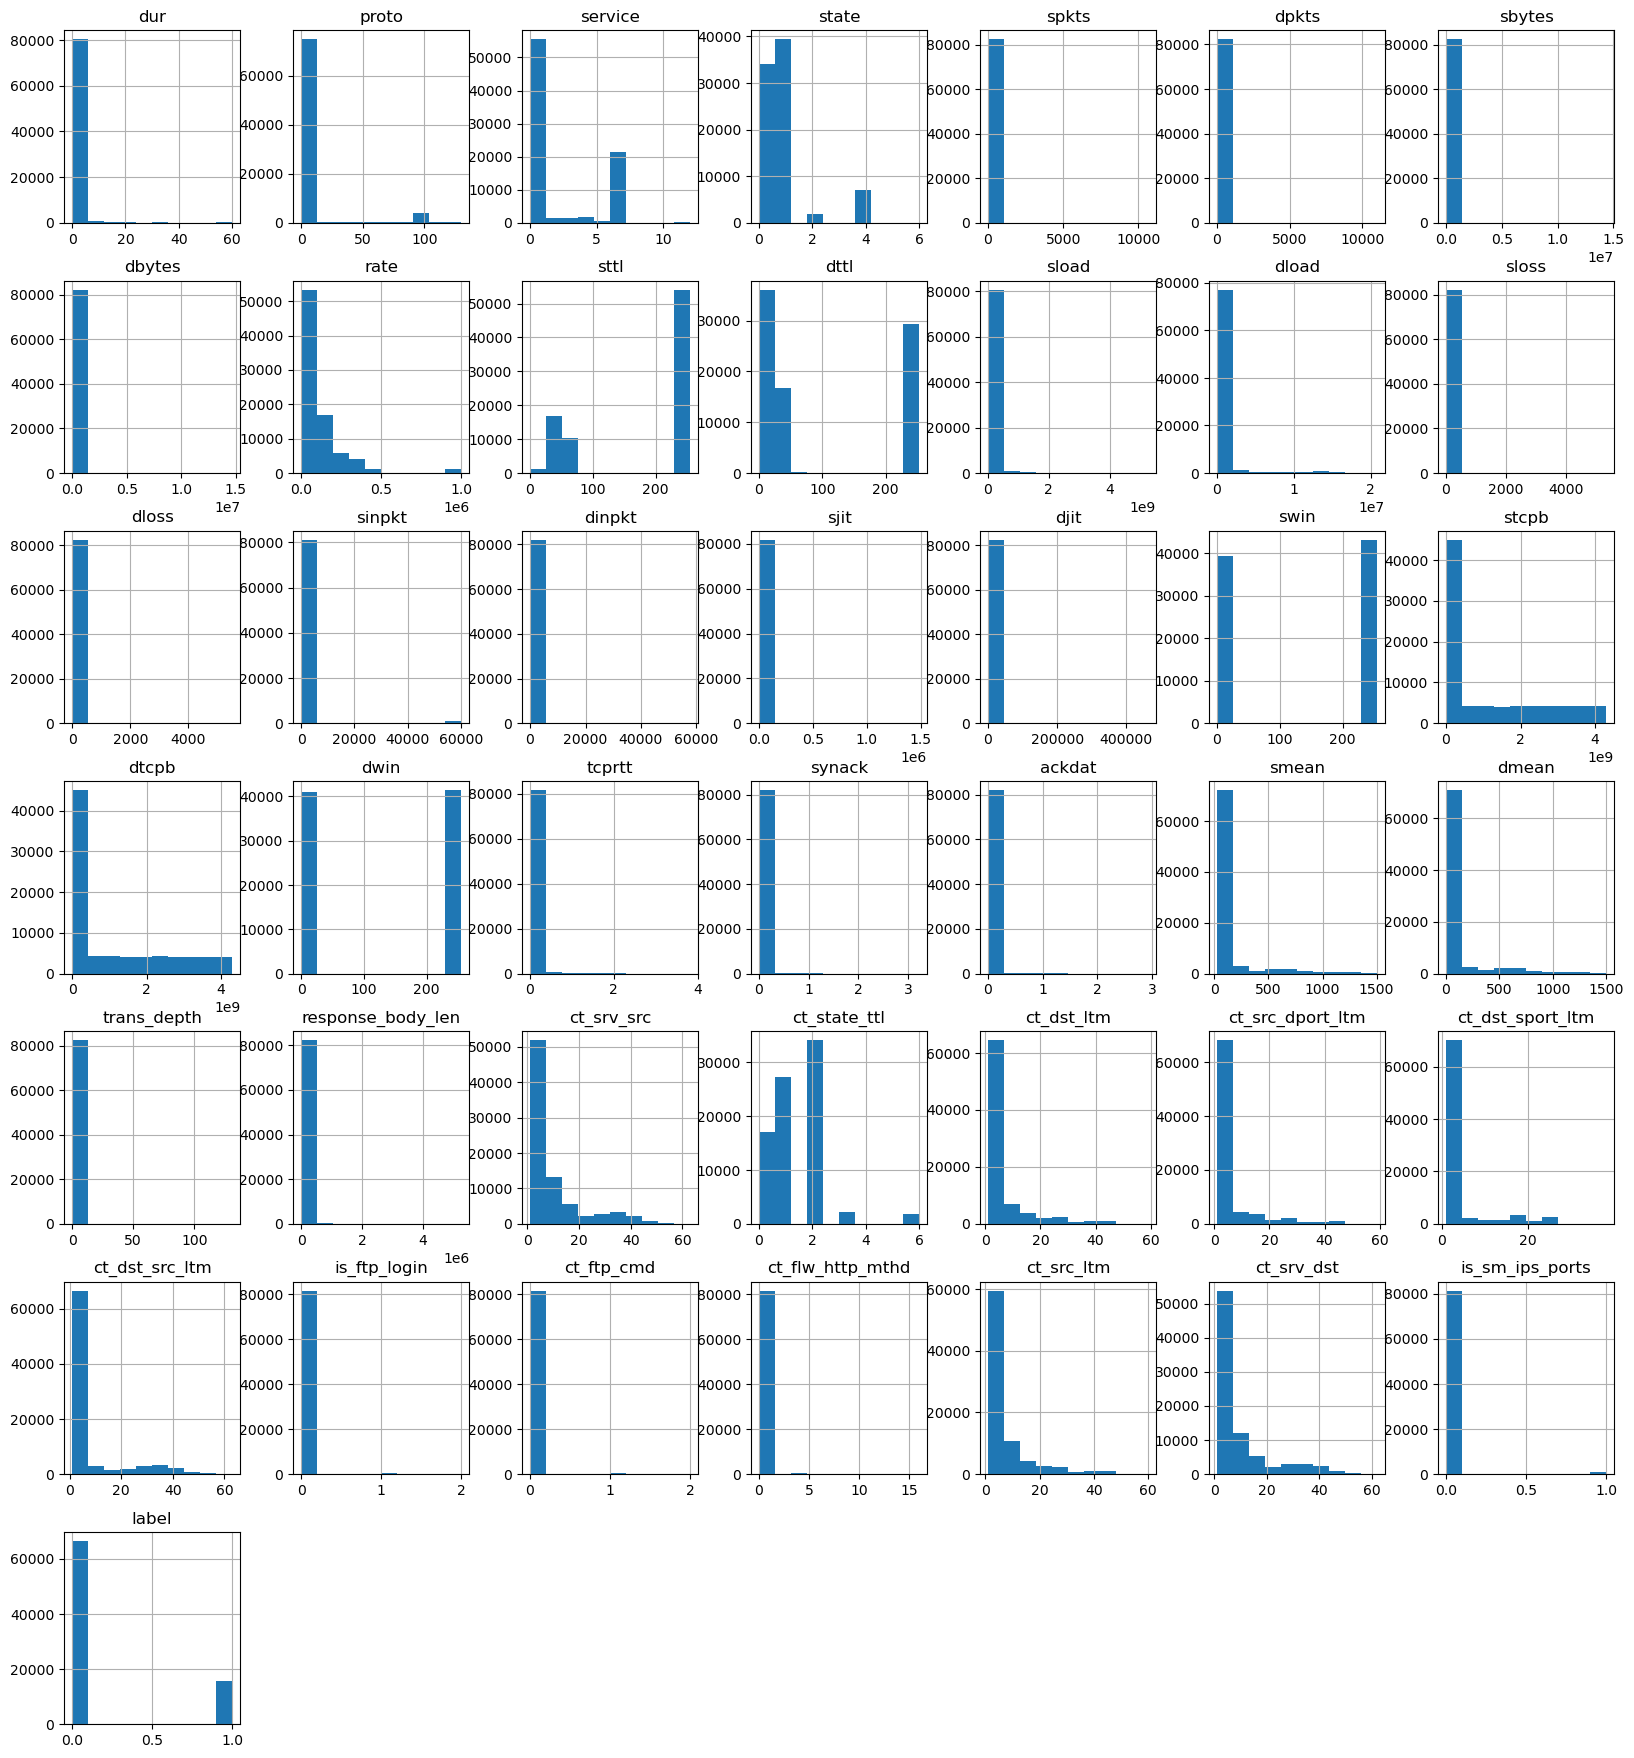

In [11]:
rcParams["figure.figsize"]=(20,22)
train_df.hist()
plt.grid()

# Prepare the data

### Convert Pandas DF to Spark DF

In [12]:
sparktrain_df = spark.createDataFrame(train_df)
sparktest_df = spark.createDataFrame(test_df)

### Feature enabler

##### for Default

In [13]:
pipeline = SparkDFPipeline(smote=False, standardize=False)
train, test = pipeline.transform(sparktrain_df, sparktest_df)

##### for Fine Tuning

In [14]:
pipeline = SparkDFPipeline(smote=True, standardize=True)
FT_train, FT_test = pipeline.transform(sparktrain_df, sparktest_df)

23/08/14 08:42:44 WARN TaskSetManager: Stage 1 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:42:44 WARN TaskSetManager: Stage 4 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:42:45 WARN TaskSetManager: Stage 7 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:42:46 WARN TaskSetManager: Stage 8 contains a task of very large size (1367 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:42:46 WARN TaskSetManager: Stage 9 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:42:49 WARN TaskSetManager: Stage 19 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


# Model selection and training
- Select machine learning models (Logistic Regression , Decision Tree, Random Forest, Multilayer perceptron).
- Split the data into training and validation sets.
- Train the selected models using the training data.

## Logistic Regression model

### Default Model

In [15]:
# usage for default model
lr_default = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
pipeline_default = Pipeline(stages=[lr_default])
model_default = pipeline_default.fit(train)  # Use the 'train' dataset

23/08/14 08:42:49 WARN TaskSetManager: Stage 22 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:42:50 WARN TaskSetManager: Stage 23 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:42:53 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/14 08:42:59 WARN TaskSetManager: Stage 60 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:42:59 WARN TaskSetManager: Stage 61 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


###  Fine-Tuning 

In [16]:
# usage for fine-tuned models
lr_tuned = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
pipeline_tuned = Pipeline(stages=[lr_tuned])
model_tuned = pipeline_tuned.fit(FT_train)  # Use the 'FT_train' dataset

23/08/14 08:43:00 WARN TaskSetManager: Stage 62 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:43:00 WARN TaskSetManager: Stage 63 contains a task of very large size (1367 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:43:00 WARN TaskSetManager: Stage 64 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:43:01 WARN TaskSetManager: Stage 67 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:43:01 WARN TaskSetManager: Stage 68 contains a task of very large size (1367 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:43:01 WARN TaskSetManager: Stage 69 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:43:09 WARN TaskSetManager: Stage 120 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08

In [17]:
# Define the stages for your pipeline
assembler = VectorAssembler(inputCols=['features'], outputCol='assembled_features')
lr = LogisticRegression(featuresCol='assembled_features', labelCol='label', maxIter=10)

# Create a pipeline with the defined stages
pipeline = Pipeline(stages=[assembler, lr])

# Define the ParamGrid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 20, 30]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

# Define the CrossValidator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=3)

# Fit the CrossValidator on your training data
cv_model = cv.fit(FT_train)



23/08/14 08:43:12 WARN TaskSetManager: Stage 130 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:43:12 WARN TaskSetManager: Stage 131 contains a task of very large size (1367 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:43:12 WARN TaskSetManager: Stage 132 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:43:18 WARN TaskSetManager: Stage 180 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:43:19 WARN TaskSetManager: Stage 181 contains a task of very large size (1367 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:43:19 WARN TaskSetManager: Stage 182 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:44:23 WARN TaskSetManager: Stage 728 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.

### Evaluation

23/08/14 08:47:15 WARN TaskSetManager: Stage 2088 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:16 WARN TaskSetManager: Stage 2099 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:17 WARN TaskSetManager: Stage 2113 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:18 WARN TaskSetManager: Stage 2116 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:18 WARN TaskSetManager: Stage 2119 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:18 WARN TaskSetManager: Stage 2122 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:19 WARN TaskSetManager: Stage 2125 contains a task of very large size (2970 KiB). The maximum recommended task size is 10

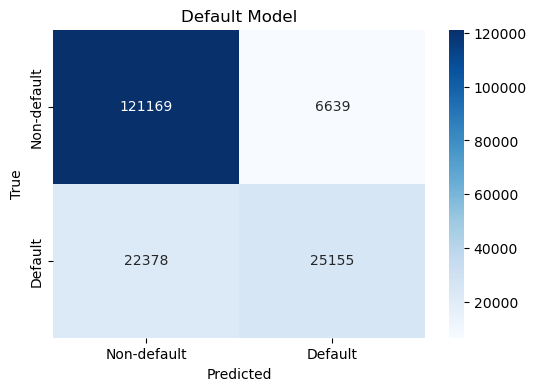

23/08/14 08:47:23 WARN TaskSetManager: Stage 2139 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:24 WARN TaskSetManager: Stage 2150 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:25 WARN TaskSetManager: Stage 2164 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:26 WARN TaskSetManager: Stage 2167 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:26 WARN TaskSetManager: Stage 2170 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:27 WARN TaskSetManager: Stage 2173 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:27 WARN TaskSetManager: Stage 2176 contains a task of very large size (2970 KiB). The maximum recommended task size is 10

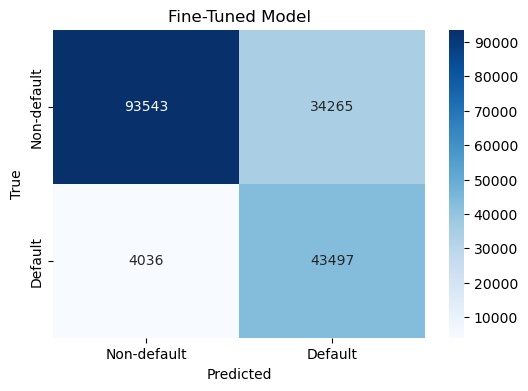

23/08/14 08:47:32 WARN TaskSetManager: Stage 2190 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:33 WARN TaskSetManager: Stage 2201 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:34 WARN TaskSetManager: Stage 2215 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:34 WARN TaskSetManager: Stage 2218 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:35 WARN TaskSetManager: Stage 2221 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:35 WARN TaskSetManager: Stage 2224 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 08:47:35 WARN TaskSetManager: Stage 2227 contains a task of very large size (2970 KiB). The maximum recommended task size is 10

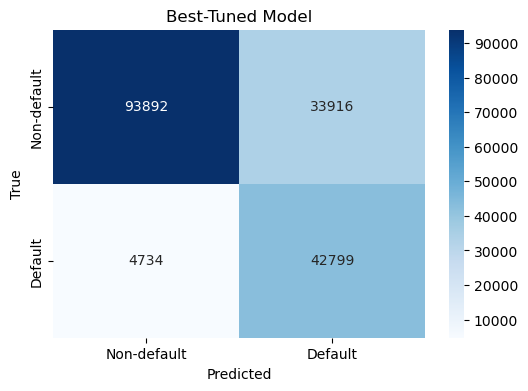

Evaluation Results:
Metric              Default Model       Fine-Tuned Model    Best-Tuned Model    
AUC                 0.8913088668659793  0.9092369798814152  0.9037982750527187  
AreaUnderPR         0.7669545478766502  0.7821015903426718  0.7697785533163136  
Sensitivity         0.5292112847916185  0.9150905686575642  0.9004060337029012  
Specificity         0.9480548948422634  0.731902541311968   0.7346331997996995  
Precision           0.181326672027649   0.443490113550168   0.43751889175948583 
Recall              0.5292112847916185  0.9150905686575642  0.9004060337029012  
F1-Score            0.27010554510080587 0.5974376428540701  0.5888890213523755  
Accuracy            0.8345110384907124  0.7815627833763923  0.7795723761128316  


In [18]:
# Evaluate models using the evaluate_model function
evaluation_results_default = evaluate_model(model_default, test, 'Default Model')  # Use the 'test' dataset

# Evaluate models using the evaluate_model function
evaluation_results_tuned = evaluate_model(model_tuned, FT_test, 'Fine-Tuned Model')  # Use the 'test' dataset

# Corrected variable name
evaluation_results_best_tuned = evaluate_model(cv_model, FT_test, 'Best-Tuned Model')  # Use the 'test' dataset


# Print evaluation results for both models side by side

print("Evaluation Results:")
print(f"{'Metric':<20}{'Default Model':<20}{'Fine-Tuned Model':<20}{'Best-Tuned Model':<20}")
print("=" * 80)

for metric in evaluation_results_default.keys():
    default_value = evaluation_results_default[metric]
    tuned_value = evaluation_results_tuned[metric]
    best_tuned_value = evaluation_results_best_tuned[metric]
    print(f"{metric:<20}{default_value:<20}{tuned_value:<20}{best_tuned_value:<20}")


##### Sci-kit Learn

In [19]:
# from sklearn.metrics import confusion_matrix, classification_report

# def evaluate_model_with_visualization(model, val_data, model_name):
#     # Make predictions on the validation data
    # predictions = model.transform(val_data)

#     # Evaluate the model using a BinaryClassificationEvaluator for AUC
#     auc_evaluator = BinaryClassificationEvaluator(labelCol='label')
#     auc = auc_evaluator.evaluate(predictions)

#     # Calculate additional metrics
#     sensitivity = predictions.filter("label = 1 and prediction = 1").count() / predictions.filter("label = 1").count()
#     specificity = predictions.filter("label = 0 and prediction = 0").count() / predictions.filter("label = 0").count()
#     precision = predictions.filter("prediction = 1").count() / predictions.filter("prediction = 1 or prediction = 0").count()
#     recall = sensitivity
#     f1_score = 2 * (precision * recall) / (precision + recall)
#     accuracy = (predictions.filter("label = prediction").count()) / predictions.count()

#     # Convert Spark DataFrames to Pandas DataFrames for visualization
#     y_true_pd = predictions.select('label').toPandas()
#     y_pred_pd = predictions.select('prediction', 'probability').toPandas()
    
#     # Convert prediction probabilities to binary predictions
#     y_pred_binary = [1 if prob[1] >= 0.5 else 0 for prob in y_pred_pd['probability']]

#     # Generate the confusion matrix
#     cm = confusion_matrix(y_true_pd['label'], y_pred_binary)

#     # Display the confusion matrix as a heatmap
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], 
#                 yticklabels=['Non-default', 'Default'])
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title(model_name)
#     plt.show()

#     # Generate the classification report
#     report = classification_report(y_true_pd['label'], y_pred_binary, target_names=['Non-default', 'Default'], output_dict=True)

#     # Create a summary table
#     summary_table = pd.DataFrame({
#         'Model': [model_name],
#         'AUC': [auc],
#         'Sensitivity': [sensitivity],
#         'Specificity': [specificity],
#         'Precision': [precision],
#         'Recall': [recall],
#         'F1-Score': [f1_score],
#         'Accuracy': [accuracy],
#         'Precision (Non-default)': [report['Non-default']['precision']],
#         'Recall (Non-default)': [report['Non-default']['recall']],
#         'F1-score (Non-default)': [report['Non-default']['f1-score']],
#         'Precision (Default)': [report['Default']['precision']],
#         'Recall (Default)': [report['Default']['recall']],
#         'F1-score (Default)': [report['Default']['f1-score']],
#     })

#     return summary_table

# # Assuming you have 'model_default' and 'test' DataFrame from your pipeline
# evaluation_results_default = evaluate_model_with_visualization(model_default, test, 'Default Model')
# print(evaluation_results_default)


In [20]:
# from sklearn.metrics import confusion_matrix

# # Assuming you have the true labels and predicted labels for your test data
# true_labels = test.select('label').rdd.flatMap(lambda x: x).collect()
# predicted_labels = model_default.transform(test).select('prediction').rdd.flatMap(lambda x: x).collect()

# # Calculate the confusion matrix
# cm = confusion_matrix(true_labels, predicted_labels)

# # Print the confusion matrix
# print("Confusion Matrix:")
# print(cm)

## Decision Tree Model

### Default Model

###  Fine-Tuning 

### Evaluation

## Random Forest Model

### Default Model

###  Fine-Tuning 

### Evaluation

## Multilayer perceptron Model

### Default Model

###  Fine-Tuning 

### Evaluation

# Final comparison between Models